In [15]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.quantum_info.operators import Operator
from cmath import exp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import classical_maxcut

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [2]:
"""Create graph"""
def generate3RegGraph (number_of_nodes = 6):
    return nx.random_regular_graph(3, number_of_nodes)

In [3]:
"""Generate any circulant graph"""
def circulant_graph(size, connections):
    rtn = nx.Graph()
    rtn.add_nodes_from(range(0,size))
    edges = []
    for distance in connections:
        edges += [(i,(i+distance)%size) for i in range(0,size)]
    rtn.add_edges_from(edges)
    return rtn

In [4]:
"""Make diagonal operator and convert to circuit"""
def parameterized_lambda(time, eigenvalues):
    diagonalized_matrix = []
    for col in range(len(eigenvalues)):
        diagonalized_matrix.append([])
        for row in range(len(eigenvalues)):
            if row == col:
                diagonalized_matrix[-1].append(exp(1j * time * eigenvalues[row]))
            else:
                diagonalized_matrix[-1].append(0)
    return Operator(diagonalized_matrix)

In [5]:
"""Quality function for any graph"""
def quality(solution,graph):
    if len(solution) != graph.number_of_nodes():
        raise RuntimeError('Maxcut potential solution is not encoded correctly.')
    quality = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            quality += 1
    return quality


'''Computes average quality of all the bitstrings outputted by the circuit, accounting for multiplicity'''
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = quality(bitstring, graph)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [6]:
def quality_quantum_circuit(graph):
    problem_register = QuantumRegister(graph.number_of_nodes(), name='psi')
    ancilla_register = QuantumRegister(graph.number_of_edges(), name='ancilla')
    qc = QuantumCircuit(problem_register, ancilla_register, name = ' quality')
    for ancilla_index, (i, j) in enumerate(graph.edges()):
        qc.cx(i, j)
        qc.cx(j, ancilla_index + graph.number_of_nodes())
        qc.cx(i, j)
    return qc

In [7]:
'''Create exp gates as shown in figure 1 of the paper'''
def exp_gate(i, gamma):
    return Operator(
        [[1, 0],
         [0, exp(-1j * (2**i) * gamma)]]
    )

In [8]:
'''Create a depth 1 QWOA circuit based on input parameters'''
def create_circuit(params, graph, eigenvalues):
    
    # extract parameters
    gamma = params[0]
    time = params[1]

    # define circuit
    problem_register = QuantumRegister(graph.number_of_nodes(), name='phi')
    ancilla_register = QuantumRegister(graph.number_of_edges(), name='ancilla')
    output_register = ClassicalRegister(graph.number_of_nodes(), name='output')
    qc = QuantumCircuit(problem_register, ancilla_register, output_register)
    
    # initialize to a superposition over all valid states (in the case of maxcut, all states are valid)
    qft_gate_rip_terry_davis = QFT(graph.number_of_nodes()-1, inverse=False).to_instruction()
    qc.append(qft_gate_rip_terry_davis, list(range(1, graph.number_of_nodes())))

    qc.barrier()

    # compute quality
    quality_gate = quality_quantum_circuit(graph).to_gate()
    qc.append(quality_gate, list(range(0, qc.num_qubits)))
    
    # apply gamma rotation to ancilla qubits
    for i in range(0,graph.number_of_edges()):
        unitary = exp_gate(i, gamma)
        qc.append(unitary, [graph.number_of_nodes()+i])
    
    # reapply quality gate
    qc.append(quality_gate, list(range(0, qc.num_qubits)))
    
    qc.barrier()
    
    #Set up fourier transform gates, look at operator matrix
    inv_qft_gate = QFT(graph.number_of_nodes(), inverse=True).to_instruction()  
    qft_gate = QFT(graph.number_of_nodes(), inverse=False).to_instruction()

    # quantum fourier transform on the solution phi
    qc.append(qft_gate, list(range(0, graph.number_of_nodes())))
    
    lambda_gate = parameterized_lambda(time, eigenvalues)
    qc.append(lambda_gate, list(range(0, graph.number_of_nodes())))

    qc.append(inv_qft_gate, list(range(0, graph.number_of_nodes())))

    qc.measure(list(range(0, graph.number_of_nodes())),list(range(0, graph.number_of_nodes())))

    return qc


In [17]:
def qwoaParameters(initial_parameters_list, graph, connectivity_list, show_graphs=False):
    #Generate the circulant graph used as the solution space
    solution_space_graph = circulant_graph(np.power(2, graph.number_of_nodes()), connectivity_list)

    #Show the graphs if desired
    if show_graphs:
        plt.figure()
        nx.draw_circular(graph, with_labels=True) #Draw the graph
        plt.title("Graph on which to perform maxcut")
        plt.show()
        plt.clf()
        plt.figure(figsize=(15,15)) 
        nx.draw_kamada_kawai(solution_space_graph, with_labels=True) #Draw the solution graph
        plt.title("Circulant solution graph on whic to walk")
        plt.show()
        plt.clf()

    return {
        "params": initial_parameters_list, 
        "graph": graph,
        #Generate eigenvalues of circulant graph
        "eigenvalues":np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0]
    }

"""Simulate circuit and train parameters"""
def runSimulation(initialParametersList, graph, connectivityList):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 512

    parameters = qwoaParameters(initialParametersList, graph, connectivityList)
    
    def execute_circ(theta):
        parameters["params"] = theta
        qc = create_circuit(**parameters)
        test = transpile(qc, backend)
        qobj = assemble(test)
        counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
        return -compute_expectation(counts, graph)


    res = minimize(execute_circ, initialParametersList, method='COBYLA')
    parameters["params"] = res.x
    qc_res = create_circuit(**parameters)

    test = transpile(qc_res, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10).result().get_counts()

    print(classical_maxcut.max_cut(graph))

    display(plot_histogram(counts,figsize=(25, 15)))

In [19]:
def qwoa (graph, connectivity_list, initial_parameters_list):
    #Generate the circulant graph used as the solution space
    solution_space_graph = circulant_graph(np.power(2, graph.number_of_nodes()), connectivity_list)

    plt.figure(figsize=(15,15)) 
    nx.draw_kamada_kawai(solution_space_graph, with_labels=True) #Draw the solution graph
    plt.show()
    plt.clf()
    plt.figure()
    nx.draw_circular(graph, with_labels=True) #Draw the graph
    plt.show()
    plt.clf()

    #Generate eigenvalues of circulant graph
    eigenvalues = np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0]

    return create_circuit(initial_parameters_list, graph, eigenvalues)

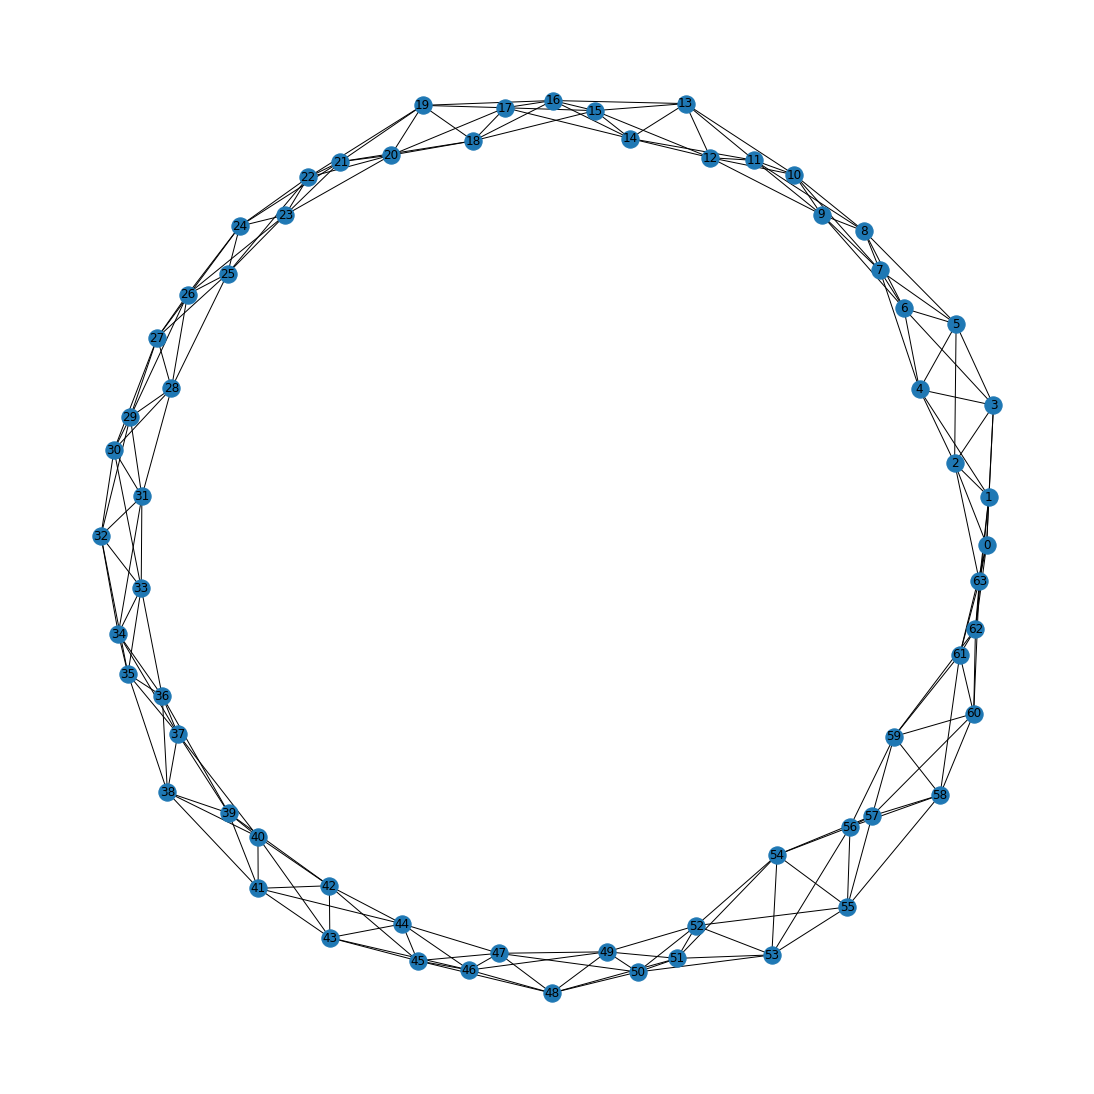

<Figure size 432x288 with 0 Axes>

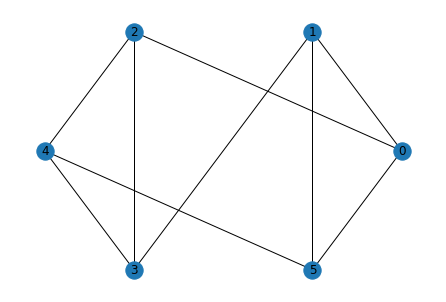

/tmp/ipykernel_15110/325718316.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  eigenvalues = np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0]
/tmp/ipykernel_15110/1734082189.py:22: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  "eigenvalues":np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0]


(7, [{0, 1, 4}, {0, 3, 4}, {0, 3, 5}])


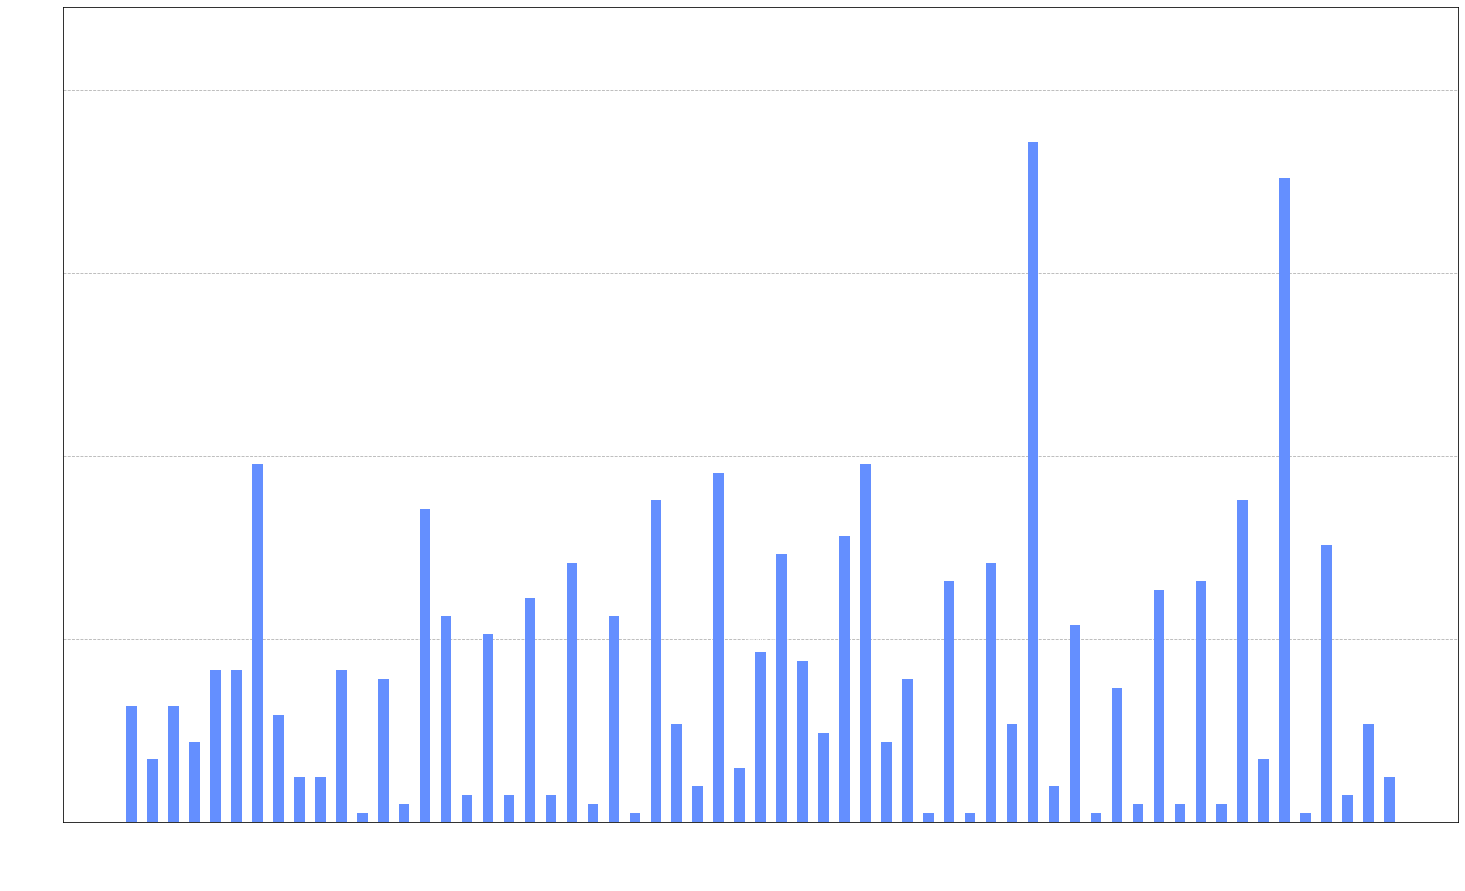

<Figure size 432x288 with 0 Axes>

In [20]:
graph = generate3RegGraph(6) #6 nodes
connectivityList = [1,2,3]
initialParametersList = [1,1]
circuit = qwoa(graph, connectivityList, initialParametersList)
circuit.draw('mpl')
runSimulation(initialParametersList, graph, connectivityList)

In [12]:
def countour_plot (cost_function, resolution=32):
    grid_values = np.linspace(0, np.pi * 2, num=resolution)
    cost_values = np.zeros((resolution, resolution))
    row = column = 0
    for gamma in grid_values:
        for time in grid_values:
            cost_values[row][column] = cost_function([gamma, time])
            column += 1
        row += 1
        column = 0
    plt.figure(figsize=(15,15)) 
    plt.contourf(grid_values, grid_values, cost_values)
    plt.axis('scaled')
    plt.colorbar()
    plt.show()

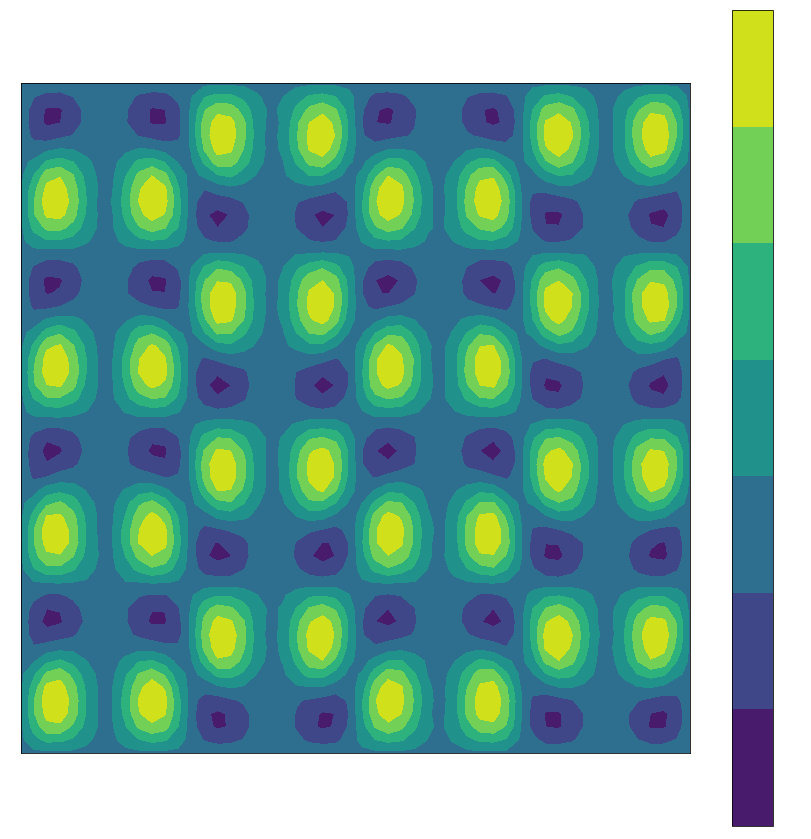

In [21]:
import maxcut_qaoa as qaoa
countour_plot(qaoa.get_expectation(graph), 52)

In [ ]:
countour_plot(execute_circ, 42)

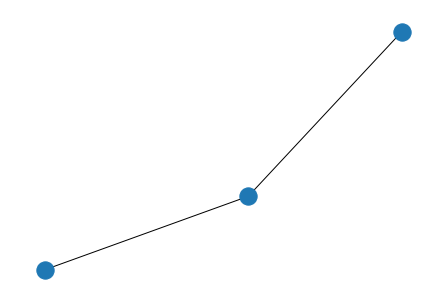

In [ ]:
small_G = nx.Graph()
small_G.add_nodes_from([0,1,2])
small_G.add_edges_from([(0,1), (1,2)])
nx.draw(small_G)

C:\Users\antsg\AppData\Local\Temp\ipykernel_17472\1358791166.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(circulant_graph(8, [1,3])).todense()


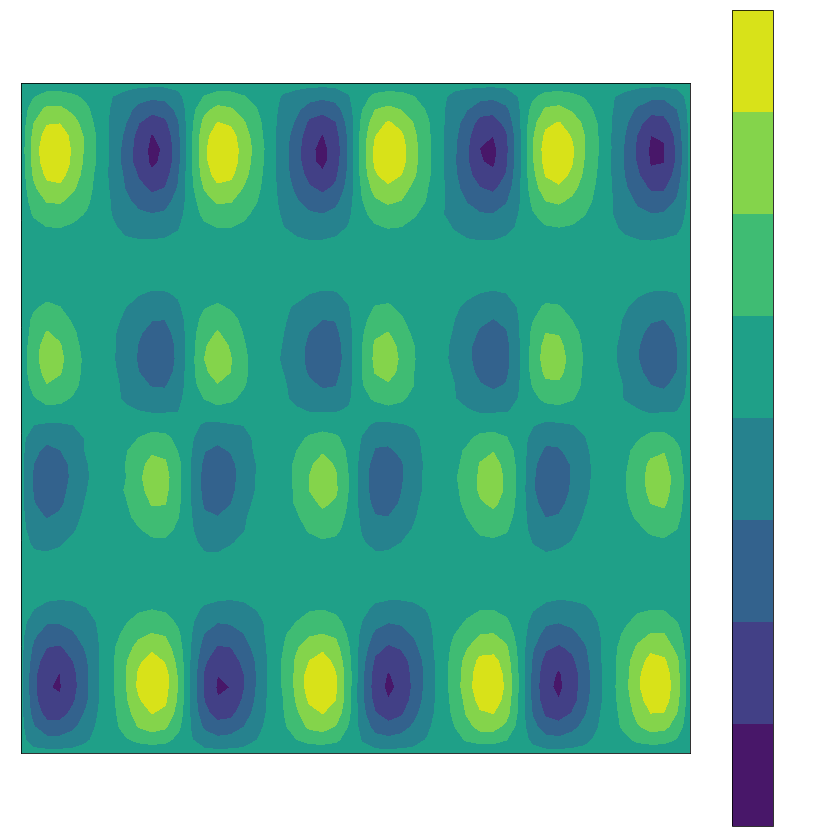

In [ ]:
data = np.linalg.eig(
    nx.adjacency_matrix(circulant_graph(8, [1,3])).todense()
)
eigenvalues = list(data[0])

def execute_circ_small_graph(theta):
    qc = create_circuit(theta, small_G, eigenvalues)
    test = transpile(qc, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
    return -compute_expectation(counts, small_G)

countour_plot(execute_circ_small_graph, 52)